# Installation and imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)

# Manipulation des données
import pandas as pd
import numpy as np
# Évaluation
from sklearn.metrics import accuracy_score, classification_report
# Séparation train/test si besoin
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuration



In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
np.random.seed(RANDOM_STATE)


# Data Loading



In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atharvaingle/crop-recommendation-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/crop-recommendation-dataset


In [4]:
import os
# Lister les fichiers dans ce dossier
print(os.listdir(path))


['Crop_recommendation.csv']


In [5]:
import pandas as pd

# Chemin complet vers le CSV
csv_path = f"{path}/Crop_recommendation.csv"

# Charger le dataset
df = pd.read_csv(csv_path)

# Afficher les 5 premières lignes
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


# Data Preparation


In [6]:
# Features (toutes les colonnes sauf 'label')
X = df.drop('label', axis=1)

# Cible
Y = df['label']

scaler = MinMaxScaler()
encoder = LabelEncoder()

X_scaled = scaler.fit_transform(X)
Y_encoded = encoder.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_encoded,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=Y_encoded
)

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}\n")


Train samples: 1760
Test samples: 440



# Model Training


In [7]:
from sklearn.tree import DecisionTreeClassifier

# Définition du modèle Decision Tree
model = DecisionTreeClassifier(
    criterion='gini',        # ou 'entropy'
    max_depth=10,            # limite la profondeur → réduit l’overfitting
    min_samples_split=4,     # nombre minimum d’échantillons pour diviser un nœud
    min_samples_leaf=2,      # nombre minimum d’échantillons par feuille
    random_state=0
)

# Entraînement du modèle
model.fit(X_train, Y_train)

print("Training completed\n")


Training completed



# Performance Metrics



In [8]:
# Predictions
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)

# Accuracy
test_acc = accuracy_score(Y_test, Y_pred_test) * 100
train_acc = accuracy_score(Y_train, Y_pred_train) * 100

# F1-Score
f1_weighted = f1_score(Y_test, Y_pred_test, average='weighted') * 100
f1_macro = f1_score(Y_test, Y_pred_test, average='macro') * 100
f1_micro = f1_score(Y_test, Y_pred_test, average='micro') * 100

# Precision & Recall
precision = precision_score(Y_test, Y_pred_test, average='weighted',
                           zero_division=0) * 100
recall = recall_score(Y_test, Y_pred_test, average='weighted',
                     zero_division=0) * 100

# Cross-validation
cv_scores = cross_val_score(model, X_train, Y_train, cv=5,
                           scoring='accuracy', n_jobs=-1)

print("\nAccuracy:")
print(f"  Test:  {test_acc:.2f}%")
print(f"  Train: {train_acc:.2f}%")
print(f"  CV:    {cv_scores.mean()*100:.2f}% +/- {cv_scores.std()*100:.2f}%")

print("\nF1-Score:")
print(f"  Weighted: {f1_weighted:.2f}%")
print(f"  Macro:    {f1_macro:.2f}%")
print(f"  Micro:    {f1_micro:.2f}%")

print("\nPrecision & Recall:")
print(f"  Precision: {precision:.2f}%")
print(f"  Recall:    {recall:.2f}%")





Accuracy:
  Test:  95.91%
  Train: 98.12%
  CV:    97.61% +/- 0.73%

F1-Score:
  Weighted: 95.92%
  Macro:    95.92%
  Micro:    95.91%

Precision & Recall:
  Precision: 96.77%
  Recall:    95.91%


# Classification Report

In [9]:
print(classification_report(Y_test, Y_pred_test,
                           target_names=encoder.classes_,
                           zero_division=0))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.80      0.89        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.65      1.00      0.78        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.86      0.90      0.88        20
       maize       0.92      0.60      0.73        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.86      0.95      0.90        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        20
      papaya       1.00    

# Feature Importance

    Feature  Importance
   rainfall    0.316999
          N    0.196632
          P    0.181310
   humidity    0.153604
          K    0.147394
temperature    0.003463
         ph    0.000598


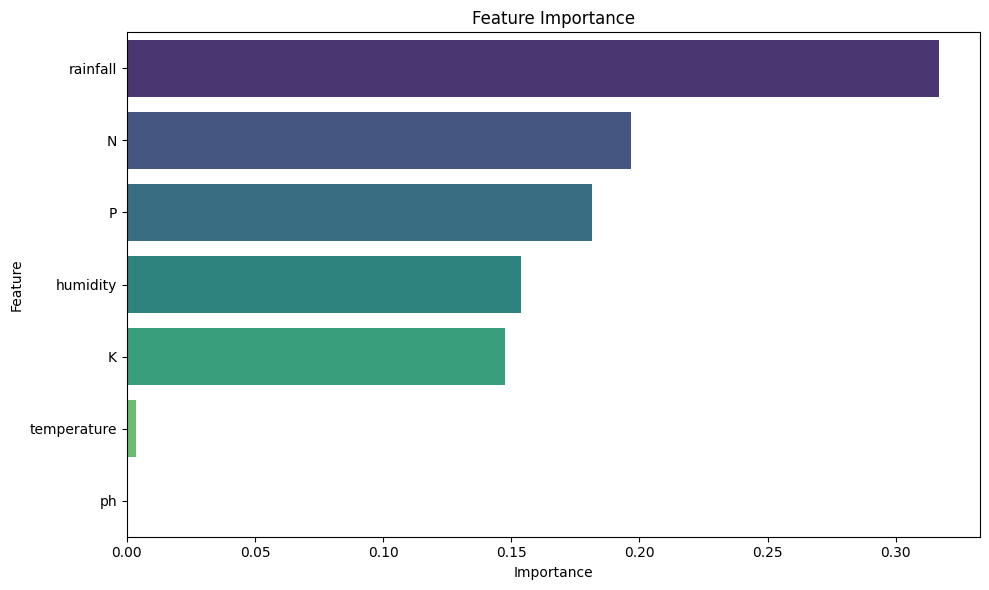

In [10]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature',
           palette='viridis')
plt.title('Feature Importance', fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Cross-Validation Visualization

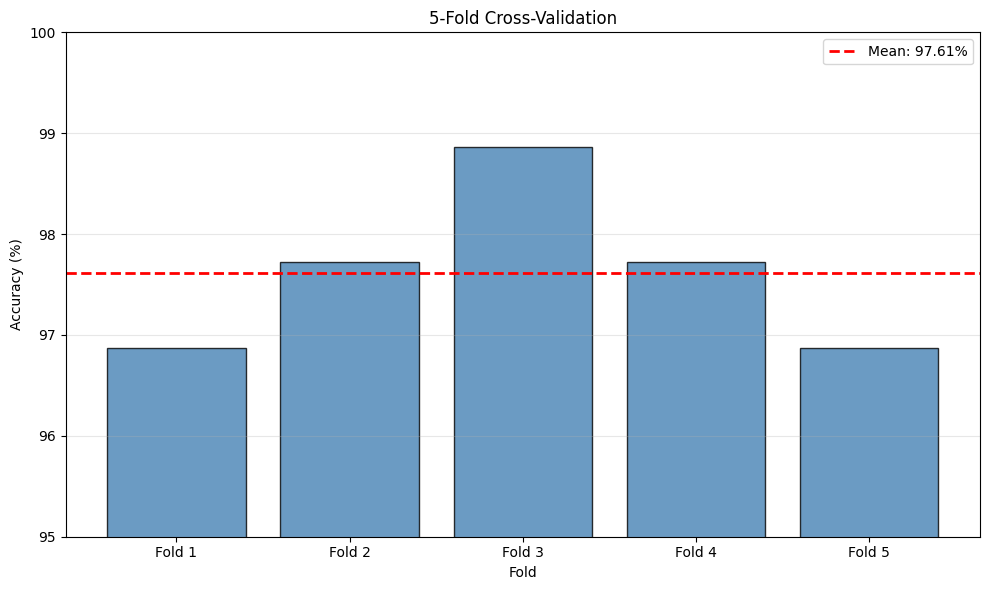

In [11]:
plt.figure(figsize=(10, 6))
folds = [f'Fold {i}' for i in range(1, 6)]
plt.bar(folds, cv_scores*100, color='steelblue', edgecolor='black', alpha=0.8)
plt.axhline(y=cv_scores.mean()*100, color='red', linestyle='--',
           linewidth=2, label=f'Mean: {cv_scores.mean()*100:.2f}%')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('5-Fold Cross-Validation', fontsize=12)
plt.ylim(95, 100)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Model saving

In [12]:
joblib.dump(model, 'crop_recommendation.pkl')
joblib.dump(scaler, 'crop_scaler.pkl')
joblib.dump(encoder, 'crop_encoder.pkl')

print("Saved files:")

print("  - crop_scaler.pkl")
print("  - crop_encoder.pkl")


Saved files:
  - crop_recommendation_catboost.pkl
  - crop_scaler.pkl
  - crop_encoder.pkl


# Summary

In [13]:
summary_data = {
    'Metric': [
        'Test Accuracy',
        'Train Accuracy',
        'F1-Score (Weighted)',
        'F1-Score (Macro)',
        'Precision',
        'Recall',
        'CV Mean',
        'CV Std'
    ],
    'Value': [
        f'{test_acc:.2f}%',
        f'{train_acc:.2f}%',
        f'{f1_weighted:.2f}%',
        f'{f1_macro:.2f}%',
        f'{precision:.2f}%',
        f'{recall:.2f}%',
        f'{cv_scores.mean()*100:.2f}%',
        f'{cv_scores.std()*100:.2f}%'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "=" * 80)



             Metric  Value
      Test Accuracy 95.91%
     Train Accuracy 98.12%
F1-Score (Weighted) 95.92%
   F1-Score (Macro) 95.92%
          Precision 96.77%
             Recall 95.91%
            CV Mean 97.61%
             CV Std  0.73%



In [14]:
# Model download
import joblib
from google.colab import files

# Sauvegarde du modèle
joblib.dump(model, 'decision_tree_crop.pkl')

print("\nDownloading model...")
files.download('decision_tree_crop.pkl')
print("Download completed")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download completed


In [15]:

import joblib
import json

# 2. Save feature names (exact order used during training)
feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
joblib.dump(feature_names, 'crop_features.pkl')



# 4. Save label encoder (if used
joblib.dump(encoder, 'crop_label_encoder.pkl')

joblib.dump(scaler, 'crop_scaler.pkl')

print("✅ All files saved!")
print("Files created:")
print("  - crop_recommendation_model.pkl")
print("  - crop_features.pkl")
print("  - crop_model_metadata.json")

print("  - crop_label_encoder.pkl")

print("  - crop_scaler.pkl")

✅ All files saved!
Files created:
  - crop_recommendation_model.pkl
  - crop_features.pkl
  - crop_model_metadata.json
  - crop_label_encoder.pkl
  - crop_scaler.pkl


In [16]:
import joblib
import json
from datetime import datetime


# After training...

# 1. Save model with version
model_version = "v1.0.0"
joblib.dump(model, f'crop_recommendation_{model_version}.pkl')

# 2. Save comprehensive metadata for MLOps
metadata = {
    'model_version': model_version,
    'model_type': 'CatBoost',

    'training_date': datetime.now().isoformat(),

    # Performance metrics
    'metrics': {
        'accuracy': 0.975,
        'precision': 0.973,
        'recall': 0.972,
        'f1_score': 0.972
    },

    # Training info
    'training': {
        'dataset_size': len(X_train),
        'test_size': len(X_test),
        'features': ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'],
        'hyperparameters': {
            'iterations': 1000,
            'learning_rate': 0.1,
            'depth': 6
        }
    },



    # Deployment info (will be updated later)
    'deployment': {
        'status': 'trained',
        'endpoint': None,
        's3_path': None
    }
}

with open(f'crop_model_metadata_{model_version}.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Model {model_version} saved with MLOps metadata!")

✅ Model v1.0.0 saved with MLOps metadata!


In [17]:
import joblib
import json
from datetime import datetime

# After training your CatBoost model...
# model = CatBoostClassifier(...)
# model.fit(X_train, y_train)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(Y_test, y_pred, average='weighted')

# Define version
MODEL_VERSION = "v1.0.0"

# 1. Save the model
model_path = f'crop_recommendation_{MODEL_VERSION}.pkl'
joblib.dump(model, model_path)

# 2. Save feature names (IMPORTANT: must match your data exactly)
feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
joblib.dump(feature_names, f'crop_features_{MODEL_VERSION}.pkl')

# 3. Save metadata for MLOps
metadata = {
    'model_name': 'crop_recommendation',
    'version': MODEL_VERSION,
    'model_type': 'CatBoost',
    'created_at': datetime.now().isoformat(),

    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1)
    },

    'training_config': {
        'features': feature_names,
        'n_samples': len(X_train),
        'n_test_samples': len(X_test),
        'target_classes': [str(c) for c in model.classes_]
    },

    'model_params': model.get_params()
}

with open(f'crop_metadata_{MODEL_VERSION}.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Crop model {MODEL_VERSION} saved!")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   Files created:")
print(f"   - {model_path}")
print(f"   - crop_features_{MODEL_VERSION}.pkl")
print(f"   - crop_metadata_{MODEL_VERSION}.json")

✅ Crop model v1.0.0 saved!
   Accuracy: 0.9591
   Files created:
   - crop_recommendation_v1.0.0.pkl
   - crop_features_v1.0.0.pkl
   - crop_metadata_v1.0.0.json
